In [ ]:
import time
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, Tensorboard

In [4]:
base_dir = "/kaggle/input/aero-and-heli/dataset_aero_heli"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
classes = ["heli", "aero"]

# Visualizing the data

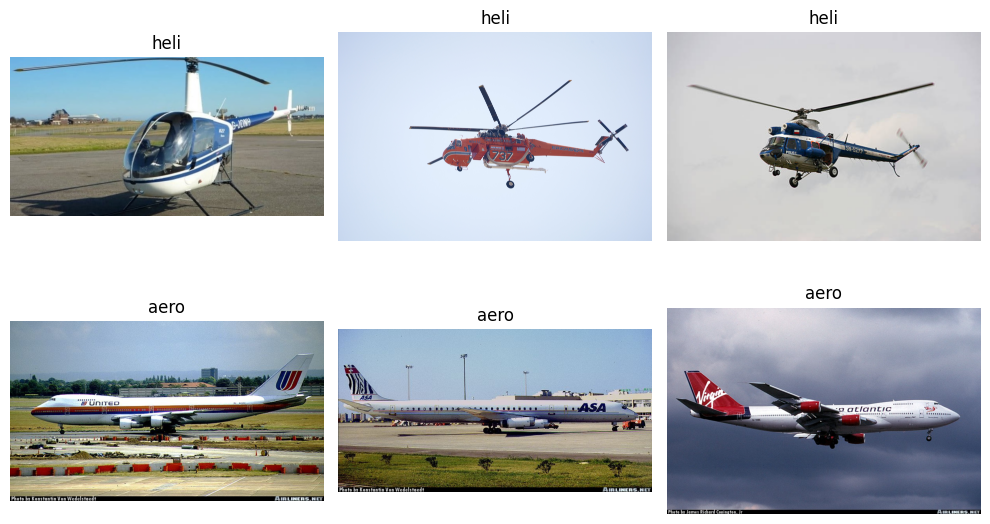

In [5]:
# Function to display sample images

def display_sample_images(train_dir, classes, num_images=3):
    plt.figure(figsize=(10, 6))

    for class_index, class_name in enumerate(classes):
        class_folder = os.path.join(train_dir, class_name)
        image_files = os.listdir(class_folder)[:num_images]  # Taking the first few images

        for i, image_file in enumerate(image_files):
            img_path = os.path.join(class_folder, image_file)
            img = load_img(img_path)  # Loading the image
            
            # Displaying the image
            plt.subplot(len(classes), num_images, class_index * num_images + i + 1)
            plt.imshow(img)
            plt.title(f"{class_name}")
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

display_sample_images(train_dir, classes)


# Preprocessing the data

In [6]:
# Data augmentation function

def augment_image(image_array):
    # Setting up a random transformation using ImageDataGenerator
    datagen = ImageDataGenerator(
        brightness_range=[0.9, 1.1],
        horizontal_flip=True,
    )
    image_array = np.expand_dims(image_array, axis=0)
    # Generating augmented image
    augmented_iter = datagen.flow(image_array, batch_size=1)
    augmented_image = next(augmented_iter)[0]

    return augmented_image

In [7]:
# Defining classes and label map

classes = ["heli", "aero"]
label_map = {class_name: idx for idx, class_name in enumerate(classes)}

# Target size for VGG-16
target_size = (224, 224)

# Function to load images with optional augmentation
def load_images_from_folder(folder, label_map, image_size=target_size, augment=False, augment_factor=2):
    images, labels = [], []
    for class_name, label in label_map.items():
        class_folder = os.path.join(folder, class_name)
        for img_file in tqdm(os.listdir(class_folder), desc=f"Processing {class_name} images"):
            img_path = os.path.join(class_folder, img_file)
            img = load_img(img_path, target_size=image_size) #Loading image and resizing
            img_array = img_to_array(img) / 255.0  # Normalizing to [0, 1]
            
            # Original image
            images.append(img_array)
            labels.append(label)
            
            # Augmentation
            if augment:
                for _ in range(augment_factor):  # Augmenting each image `augment_factor` times
                    augmented_image = augment_image(img_array)
                    images.append(augmented_image)
                    labels.append(label)
    
    return np.array(images), np.array(labels)

# Augmented training data
X_train_aug, y_train_aug = load_images_from_folder(train_dir, label_map, augment=True, augment_factor=2)

# Non-augmented training data
X_train, y_train = load_images_from_folder(train_dir, label_map, augment=False)

# Test data (no augmentation)
X_test, y_test = load_images_from_folder(test_dir, label_map, augment=False)

print("Augmented training data shape:", X_train_aug.shape, y_train_aug.shape)
print("Non-augmented training data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Processing aero images: 100%|██████████| 20/20 [00:00<00:00, 97.11it/s]

Augmented training data shape: (480, 224, 224, 3) (480,)
Non-augmented training data shape: (160, 224, 224, 3) (160,)
Test data shape: (40, 224, 224, 3) (40,)


In [ ]:
# # Saving and loading all arrays as .npy files

# np.save('dataset_aero_heli\npy\X_train_augmented.npy', X_train_aug)
# np.save('dataset_aero_heli\npy\y_train_augmented.npy', y_train_aug)
# np.save('dataset_aero_heli\npy\X_train.npy', X_train)
# np.save('dataset_aero_heli\npy\y_train.npy', y_train)
# np.save('dataset_aero_heli\npy\X_test.npy', X_test)
# np.save('dataset_aero_heli\npy\y_test.npy', y_test)

# X_train_aug = np.load(r'dataset_aero_heli\npy\X_train_augmented.npy')
# y_train_aug = np.load(r'dataset_aero_heli\npy\y_train_augmented.npy')
# X_train = np.load(r'dataset_aero_heli\npy\X_train.npy')
# y_train = np.load(r'dataset_aero_heli\npy\y_train.npy')
# X_test = np.load(r'dataset_aero_heli\npy\X_test.npy')
# y_test = np.load(r'dataset_aero_heli\npy\y_test.npy')


In [10]:
# 1 Block model

def model_1_block():
    model=Sequential()
    # block 1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
    model.add(MaxPooling2D((2, 2)))
    # FC layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
# 3 Block model

def model_3_block():
    model=Sequential()
    # block 1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
    model.add(MaxPooling2D((2, 2)))
    # block 2
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # block 3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # FC layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [12]:
def vgg_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = True
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = Adam(learning_rate=0.001)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

	return model

In [13]:
def vgg_model_2():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = Adam(learning_rate=0.001)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

	return model

In [18]:
# Initialize model

def train_and_predict(model, epoch, x, y):
    if (model=="1_block"):
        model = model_1_block()
    elif (model=="3_block"):
        model = model_3_block()
    elif (model=="vgg_16"):
        model = vgg_model()
    elif (model=="vgg_16_2"):
        model = vgg_model_2()

    start_time = time.time()
    print_loss_callback = LambdaCallback(
        on_batch_end=lambda batch, logs: print(f" Batch {batch}, Loss: {logs['loss']:.4f}")
    )
    # Fit model with callback to print loss at each iteration
    model.fit(x, y, epochs=epoch, callbacks=[print_loss_callback])
    end_time = time.time()
    training_time = end_time - start_time
    print(f"\n------------\nTraining Time: {training_time / epoch} per epoch\n-------------\n")

    y_hat = model.predict(X_test)
    correct=0
    for i in range(len(y_hat)):
        if y_test[i]==round(y_hat[i][0]):
            correct+=1
            
    print(correct, len(y_hat))
    accuracy=correct/len(y_hat)
    print("Accuracy: ", accuracy)

In [15]:
def show_img(y_hat, y_test):
    plt.figure(figsize=(15, 15))
    
    # Number of images to display (all images in X_test)
    num_images = len(X_test)
    
    for i in range(num_images):
        plt.subplot(int(np.sqrt(num_images)) + 1, int(np.sqrt(num_images)) + 1, i + 1)
        plt.imshow(X_test[i], cmap='gray')  # Use 'gray' for grayscale images or remove cmap for RGB
        plt.title(f"True: {y_test[i]}, Pred: {y_hat[i][0]:.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [19]:
# Model Block_1
model = "1_block"
epoch = 10
train_and_predict(model, epoch, X_train, y_train)

Epoch 1/10
 Batch 0, Loss: 0.6988
1/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5000 - loss: 0.6988 Batch 1, Loss: 15.5096
 Batch 2, Loss: 20.3394
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5347 - loss: 12.1826 Batch 3, Loss: 15.9972
 Batch 4, Loss: 13.4906
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5642 - loss: 13.2544
Epoch 2/10
 Batch 0, Loss: 3.2786
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7812 - loss: 3.2786 Batch 1, Loss: 6.1391
 Batch 2, Loss: 4.3797
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7257 - loss: 4.5992 Batch 3, Loss: 4.3300
 Batch 4, Loss: 4.2325
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7365 - loss: 4.4321
Epoch 3/10
 Batch 0, Loss: 1.1857
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9062 - loss: 1.1857 Batch 1, Loss: 0.8657
 Batch 2, Loss: 0.7154
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9306 - loss: 0.9223 Batch 3, Loss: 0.9331
 Batch 4, Loss: 1.4233
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy

In [23]:
# Model Block_3
model = "1_block"
epoch = 10
train_and_predict(model, epoch, X_train_aug, y_train_aug)

Epoch 1/10
 Batch 0, Loss: 0.6757
 1/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5000 - loss: 0.6757 Batch 1, Loss: 4.9696
 Batch 2, Loss: 7.6664
 3/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4757 - loss: 4.4372 Batch 3, Loss: 13.6928
 Batch 4, Loss: 18.6576
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4935 - loss: 9.1324 Batch 5, Loss: 17.5783
 Batch 6, Loss: 15.2705
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5054 - loss: 11.2158 Batch 7, Loss: 15.4806
 Batch 8, Loss: 15.8597
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5140 - loss: 12.2057 Batch 9, Loss: 15.6192
 Batch 10, Loss: 14.7047
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5204 - loss: 12.7432 Batch 11, Loss: 13.9950
 Batch 12, Loss: 13.4199
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5255 - loss: 12.8915 Batch 13, Loss: 12.5585
 Batch 14, Loss: 11.7513
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5322 - loss: 12.7282
Epoch 2/10
 Batch 0, Loss: 1.3012
 1/1

In [21]:
# Model Block_3
model = "3_block"
epoch = 10
train_and_predict(model, epoch, X_train, y_train)

Epoch 1/10
 Batch 0, Loss: 0.6981
1/5 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.5625 - loss: 0.6981 Batch 1, Loss: 1.5135
 Batch 2, Loss: 2.3115
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5139 - loss: 1.5077 Batch 3, Loss: 2.2734
 Batch 4, Loss: 1.9217
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5168 - loss: 1.7733
Epoch 2/10
 Batch 0, Loss: 0.7084
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5000 - loss: 0.7084 Batch 1, Loss: 0.6610
 Batch 2, Loss: 0.6323
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5122 - loss: 0.6672 Batch 3, Loss: 0.5864
 Batch 4, Loss: 0.5547
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5811 - loss: 0.6162
Epoch 3/10
 Batch 0, Loss: 0.2579
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9375 - loss: 0.2579 Batch 1, Loss: 0.2711
 Batch 2, Loss: 0.2664
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9167 - loss: 0.2651 Batch 3, Loss: 0.2335
 Batch 4, Loss: 0.2208
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9

In [22]:
# Model Block_3
model = "3_block"
epoch = 10
train_and_predict(model, epoch, X_train_aug, y_train_aug)

Epoch 1/10
 Batch 0, Loss: 0.6913
 1/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.6562 - loss: 0.6913 Batch 1, Loss: 0.6313
 2/15 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6641 - loss: 0.6613 Batch 2, Loss: 1.3542
 3/15 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6441 - loss: 0.8923 Batch 3, Loss: 1.1649
 Batch 4, Loss: 1.1262
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6427 - loss: 0.9936 Batch 5, Loss: 1.1078
 Batch 6, Loss: 1.0395
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6354 - loss: 1.0165 Batch 7, Loss: 0.9857
 Batch 8, Loss: 0.9515
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6332 - loss: 1.0058 Batch 9, Loss: 0.9061
 Batch 10, Loss: 0.8779
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6336 - loss: 0.9851 Batch 11, Loss: 0.8478
 Batch 12, Loss: 0.8232
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6342 - loss: 0.9621 Batch 13, Loss: 0.8012
 Batch 14, Loss: 0.7881
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.63

In [25]:
# Model VGG with tuning all layers
model = "vgg_16"
epoch = 10
train_and_predict(model, epoch, X_train, y_train)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
 Batch 0, Loss: 0.6929
1/5 ━━━━━━━━━━━━━━━━━━━━ 2:52 43s/step - accuracy: 0.5625 - loss: 0.6929 Batch 1, Loss: 6.0535
2/5 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step - accuracy: 0.5469 - loss: 3.3732 Batch 2, Loss: 4.2661
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.5451 - loss: 3.6708 Batch 3, Loss: 3.3863
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.5378 - loss: 3.5997 Batch 4, Loss: 2.8407
5/5 ━━━━━━━━━━━━━━━━━━━━ 45s 411ms/step - accuracy: 0.5335 - loss: 3.3467
Epoch 2/10
 Batch 0, Loss: 1.0084
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step - accuracy: 0.5938 - loss: 1.0084 Batch 1, Loss: 72.1643
2/5 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step - accuracy: 0.5781 - loss: 36.5864 Batch 2, Loss: 48.8934
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.5764 - loss: 40.6887 Batch 3, Loss: 36.9038
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.5788 - loss: 39.7425 Batch 4, Loss: 29.7009
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step -

In [26]:
# Model VGG with tuning all layers
model = "vgg_16"
epoch = 10
train_and_predict(model, epoch, X_train_aug, y_train_aug)

Epoch 1/10
 Batch 0, Loss: 0.6911
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:16 5s/step - accuracy: 0.5312 - loss: 0.6911 Batch 1, Loss: 1.9263
 2/15 ━━━━━━━━━━━━━━━━━━━━ 4s 377ms/step - accuracy: 0.5312 - loss: 1.3087 Batch 2, Loss: 3.9036
 3/15 ━━━━━━━━━━━━━━━━━━━━ 4s 377ms/step - accuracy: 0.5278 - loss: 2.1737 Batch 3, Loss: 3.1012
 4/15 ━━━━━━━━━━━━━━━━━━━━ 4s 379ms/step - accuracy: 0.5228 - loss: 2.4055 Batch 4, Loss: 2.6079
 5/15 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - accuracy: 0.5232 - loss: 2.4460 Batch 5, Loss: 2.3204
 6/15 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - accuracy: 0.5220 - loss: 2.4251 Batch 6, Loss: 2.1217
 7/15 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - accuracy: 0.5169 - loss: 2.3818 Batch 7, Loss: 1.9410
 8/15 ━━━━━━━━━━━━━━━━━━━━ 2s 376ms/step - accuracy: 0.5119 - loss: 2.3267 Batch 8, Loss: 1.9651
 9/15 ━━━━━━━━━━━━━━━━━━━━ 2s 376ms/step - accuracy: 0.5090 - loss: 2.2865 Batch 9, Loss: 1.8360
10/15 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step - accuracy: 0.5081 - loss: 2.2414 Batch 10, Loss: 1.7

In [27]:
# Model VGG with tuning mlp layers
model = "vgg_16_2"
epoch = 10
train_and_predict(model, epoch, X_train, y_train)

Epoch 1/10
 Batch 0, Loss: 0.8240
1/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4688 - loss: 0.8240 Batch 1, Loss: 0.4694
2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5859 - loss: 0.6467 Batch 2, Loss: 0.3359
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6580 - loss: 0.5431 Batch 3, Loss: 0.2558
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7064 - loss: 0.4713 Batch 4, Loss: 0.3281
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.7543 - loss: 0.4235
Epoch 2/10
 Batch 0, Loss: 0.0265
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9688 - loss: 0.0265 Batch 1, Loss: 0.0228
2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9766 - loss: 0.0246 Batch 2, Loss: 0.0812
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9740 - loss: 0.0435 Batch 3, Loss: 0.1511
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9688 - loss: 0.0704 Batch 4, Loss: 0.1247
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9667 - loss: 0.0885
Epoch 3/10
 Batch 0, Loss: 0.

In [28]:
# Model VGG with tuning mlp layers
model = "vgg_16_2"
epoch = 10
train_and_predict(model, epoch, X_train_aug, y_train_aug)

Epoch 1/10
 Batch 0, Loss: 0.7054
 1/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5312 - loss: 0.7054 Batch 1, Loss: 2.3772
 2/15 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.5000 - loss: 1.5413 Batch 2, Loss: 1.8840
 3/15 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.4826 - loss: 1.6556 Batch 3, Loss: 1.7259
 4/15 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4792 - loss: 1.6731 Batch 4, Loss: 1.4876
 5/15 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.4821 - loss: 1.6360 Batch 5, Loss: 1.3648
 6/15 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4903 - loss: 1.5908 Batch 6, Loss: 1.2298
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5012 - loss: 1.5392 Batch 7, Loss: 1.1354
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5123 - loss: 1.4888 Batch 8, Loss: 1.0597
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5229 - loss: 1.4411 Batch 9, Loss: 1.0052
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5322 - loss: 1.3975 Batch 10, Loss: 0.94